<a href="https://colab.research.google.com/github/Aerospace87/ML-projects/blob/main/Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import yfinance as yf
import pandas as pd
import numpy as np
from numpy.fft import fftfreq

In [11]:
code_dict = {
    "Caterpillar Inc.": "CAT",
    "CNH Industrial N.V.": "CNH",
    "GE Aerospace" :"GE"
}

cat = yf.Ticker(code_dict["GE Aerospace"])

In [12]:
# get historical market data
hist = cat.history(period="max")

In [13]:
hist = hist["Open"].to_frame()

In [14]:
# Convert the index from timestamp to date
hist = hist.reset_index()
hist["Date"] = hist["Date"].dt.date
hist = hist.set_index("Date")

<Axes: xlabel='Date'>

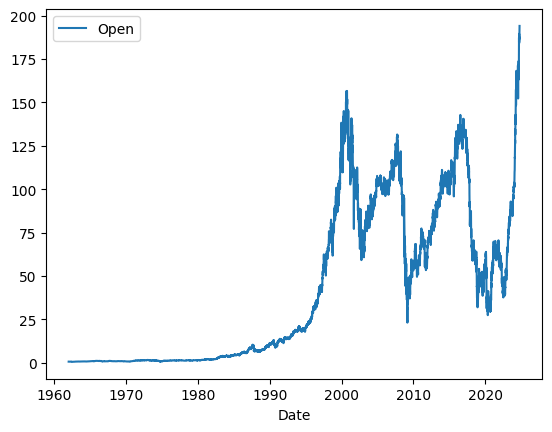

In [15]:
hist.reset_index().plot(x="Date",y="Open")

## Imputing Missing Values
For some timesteps some values may be missing therefore we impute cnsidering the last not-null value

In [16]:
# Check if all the data points are equally spaced

beginning_timestamp = hist.index.min()
last_timestamp = hist.index.max()
delta_t = hist.index[1] - beginning_timestamp


equispaced_index = pd.date_range(start = beginning_timestamp,
              end = last_timestamp,
              freq = delta_t
)

equispaced_df = pd.DataFrame(index = equispaced_index,
             data = {"test_col" : np.zeros(equispaced_index.size)}
).reset_index()


equispaced_df["index"] = equispaced_df["index"].dt.date

hist = equispaced_df.merge(hist.reset_index(),
                    how='left',
                    left_on = 'index',
                    right_on='Date'
)

cols = ["index", "Open"]

hist = hist[cols]

In [17]:
# Imputing the nulls with the last non null value

nulls_indices = hist[hist["Open"].isna()].index.copy()

for idx in nulls_indices:

  if idx == 0:
    hist.iloc[(idx, 1)] = 0.0
  elif idx >= 1:
    hist.iloc[(idx, 1)] = hist.iloc[(idx - 1, 1)]

hist.rename(columns={"index": "Date"}, inplace=True)

hist = hist.set_index("Date")

In [18]:
hist.describe()

,Open
count,22935.000000
mean,41.626818
std,45.479609
min,0.468906
25%,1.396494
50%,17.714259
75%,79.410684
max,194.089996


## Moving Average Derivation

Suppose we have a time series:

\begin{align}
x_t \hspace{2cm} t=0,1,..,T-1
\end{align}


And its cumulative sum:

\begin{align}
c_t = \sum_{i=0}^t x_i
\end{align}

And we want to compute the moving average at time step $t$, by considering the $w$ previous time steps ($t$ is also included):

\begin{align}
\overline{x}_t = \frac{1}{w} \sum_{i = t-w+1}^t x_i \hspace{2cm} \, for \, t = w-1,...,T-1.
\end{align}

The cumulative sum at time $t$ can be written as:

\begin{align}
c_t = \sum_{i=0}^t x_i = \sum_{i=0}^{t-w} x_i \, + \, \sum_{i=t-w+1}^{t} x_i = c_{t-w} \, + \, w\, \overline{x}_t
\end{align}

The previous formula is defined for $t=w,...,T-1$ as can be seen by inspecting the upper extreme of the first sum and considering that $x_t$ is definited for $t\ge0$, therefore:

\begin{align}
\overline{x}_t = \frac{1}{w}(c_t - c_{t-w}) \hspace{2cm} t=w,...,T-1.
\end{align}

To find $\overline{x}_t$ at time $t=w-1$ we use the definition:

\begin{align}
\overline{x}_{w-1} = \frac{1}{w} \sum_{i = (w-1)-w+1}^{w-1} x_i = \frac{1}{w} \sum_{i = 0}^{w-1} x_i = \frac{1}{w} c_{w-1}.
\end{align}

Overall, the moving average can be computed via:

\begin{cases}
      \overline{x}_{w-1} = \frac{1}{w} c_{w-1}\\
      \overline{x}_t = \frac{1}{w}(c_t - c_{t-w}) \hspace{2cm} t=w,...,T-1.
\end{cases}


### Algorithm definition

If we want to use a unique array called mov we can implement the following algorithm:

1. Define variable **mov** as the cumulative average.
2. Modify the elemnts of the array mov from the index $w$ by using
   the difference:
   
   **mov[w:] = mov[w:] - mov[:-w]**

3. Note that mov[w-1] has still the initial value equal to the
   cumulative sum at $t=w-1$ therefore we return the array:

   **(1/w)  mov[w-1:]**


This algorithm is implemented in the function moving_average_forecast:

In [19]:
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast
     This implementation is *much* faster than the previous one"""
  mov = np.cumsum(series)

  # This is necessary because to subtract two pandas series it is necessary
  # That both series have the same index. Therefore we force the series
  # mov[window_size:] and mov[:-window_size] to have the same index

  index = pd.Index(
      list(
          range(mov.size - window_size)
      )
  )

  mov[window_size:] = mov[window_size:].set_axis(index)- mov[:-window_size].set_axis(index)

  return mov[window_size - 1:] / window_size

In [20]:
window_size = 1

mov_average_col = "Open_mov_avg"
hist[mov_average_col] = moving_average_forecast(hist["Open"], window_size)

<Axes: xlabel='Date'>

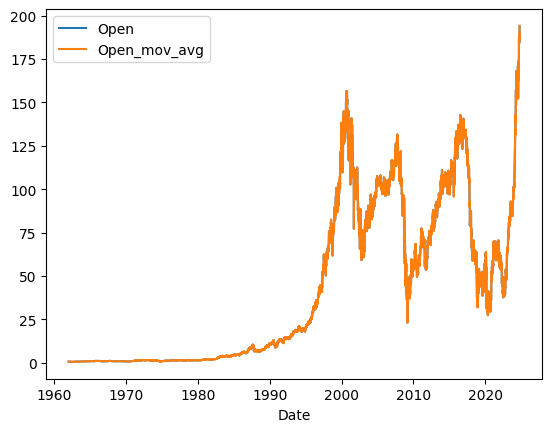

In [21]:
hist.reset_index().plot(x="Date", y= ["Open", "Open_mov_avg"])

### First Difference

The first difference is defined as:
$d_t = x_t - x_{t-q} \hspace{2cm} t=q,..., T-1$

Therefore it can be implemenentate in the function diff_series following the algoritm:

1. Define the original series as the variable **series**

2. Return the difference **series[q:] - series[:-q]**

In [22]:
def diff_series(series, q):
  original_index = series.index.copy()

  # saving te first q values in cae we want to recnstruct te original
  # series
  first_q_values = series[:q].to_numpy(copy=True)

  # Removal of the first t0-1 indices
  original_index = original_index.delete(list(range(q)))

  # conversion into numpy array to avoid indices mismatches
  series = series[q:].to_numpy(copy=True) - series[:-q].to_numpy(copy=True)

  # Returning the final pandas series from the previous numpy array
  return pd.Series(series, index=original_index), first_q_values, original_index

In [23]:
hist["Open_diff"], first_q_values, original_index =  diff_series(hist["Open"], 3)

<Axes: xlabel='Date'>

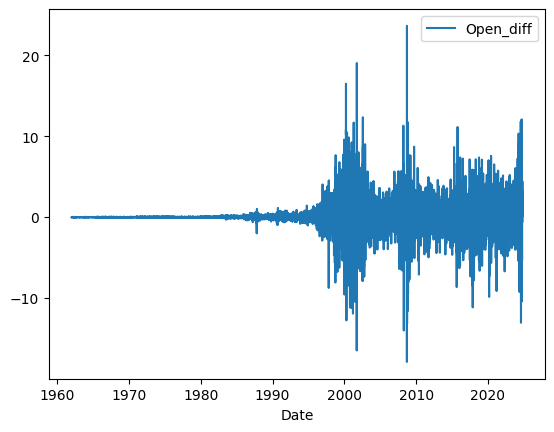

In [24]:
hist.reset_index().plot(x="Date", y="Open_diff")

### Series Integration

In order to reconstruct the original series from the differenced one we consider the first difference written for te first term of te original series as:

$x_{t_0+q}=  x_{t_0} + d_{t_0+q} \hspace{1cm} t_0=0, ...,q-1$

$x_{t_0+2q}=  x_{t_0 + q} + d_{t_0+2q} \hspace{1cm} t_0=0, ...,q-1$

Therefore:

$x_{t_0+2q}=  x_{t_0} + d_{t_0+q} + d_{t_0+2q} \hspace{1cm} t_0=0, ...,q-1$

Reasoning by induction we find then:

$x_{t_0+nq}=  x_{t_0} + \sum_{k=1}^n d_{t_0+kq}  \hspace{1cm} t_0=0, ...,q-1$

if we definw the $q$ subseries:

$d^0 = d_{t_0 + kq}  \hspace{1cm} k=1,...,n$ we apply cumulative sum and add $x_{t_0}$ we find the subseries $x_{t_0+nq}$. All the $q$ subseries (obtained by changing $t_0$) can be then used to reconstruct the full original series $x_t$.


In [25]:
def integrate_series(first_q_values, series):

  """Function to reconstruct a differenced time series given the first
     q  values of the original series"""

  original_index = series.index

  q = first_q_values.size
  T = series.size

  # Creation of an annay of zeros with the final size of the time series
  result = np.zeros(shape= T)

  # Restablishing the first q values of the original series
  result[:q] = first_q_values

  # Creation of the q subseries
  for t0 in range(q):
    sub_series = series[t0+q::q].to_numpy()

    sub_series = first_q_values[t0] + np.cumsum(sub_series)

    # Population of the subseries
    for k in range(len(sub_series)):
      result[t0 + (k+1)*q] = sub_series[k]

  return pd.Series(result, index = original_index)

In [26]:
hist["Open_diff_integrated"] = integrate_series(first_q_values, hist["Open_diff"])

<Axes: xlabel='Date'>

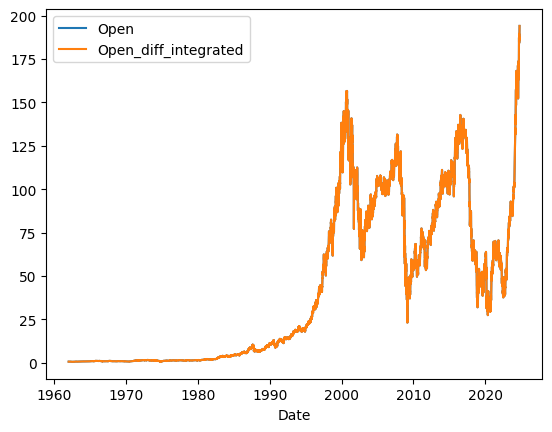

In [27]:
hist.reset_index().plot(x="Date", y= ["Open", "Open_diff_integrated"])

## Training and Validation Test Split

In [28]:
number_time_steps = hist.shape[0]
train_perc = 80.0
train_index = int(np.floor(number_time_steps * train_perc/100.0))

train_set = hist.iloc[:train_index]
val_set = hist.iloc[train_index:]

## Naive Forecast

Naive forecast predicts value at time $t+1$ as equal to the value of the series at time $t$. This will be our baseline model to evaluate all the models against it. Note that naive forecast $\hat{x}_{t+1}$ is equivalent to moving average $\overline{x}_t$ at time $t$ with $w=1$ in fact:

\begin{align}
\hat{x}_{t+1} \approx \overline{x}_t = \frac{1}{1} \sum_{i = t-1+1}^t x_i = \sum_{i = t}^t x_i = x_{t}
\end{align}


In [29]:
data_one_time_tep_before = hist["Open"][train_index - 1:-1].values

val_set["naive_forecast"] = pd.Series(data = data_one_time_tep_before, index =val_set.index )

<ipython-input-29-c56b9a4f2e39>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_set["naive_forecast"] = pd.Series(data = data_one_time_tep_before, index =val_set.index )


<Axes: xlabel='Date'>

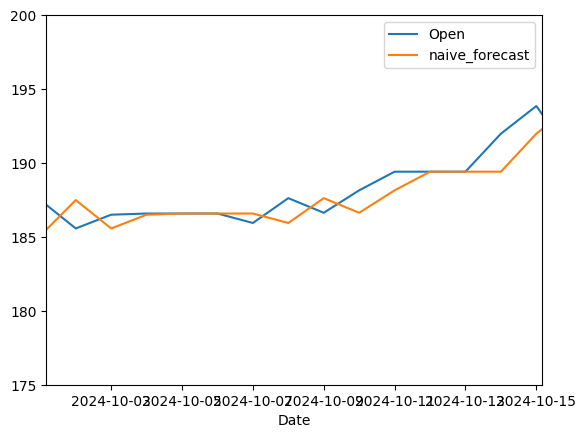

In [30]:
val_set.reset_index().plot(x="Date",
                           y=["Open", "naive_forecast"],
                           xlim = ('2024-10-01 00:00:00-04:00', '2024-10-15 00:00:00-04:00'),
                           ylim = (175, 200))

In [31]:
errors = val_set["Open"] - val_set["naive_forecast"]
abs_errors = np.abs(errors)
MAE = abs_errors.mean()
print(f"The Mean Absolute Error (MAE) for the naive forecast is {MAE}")

The Mean Absolute Error (MAE) for the naive forecast is 0.6947117452543513


## Moving Average Forecast

### Fourier Transform
Fourier transform and Power Spectral Density (PSD) are used to find seasonality in the timeseries. The frequencies of seasonality may be identifying by peaks in the PSD.

In [32]:
from scipy.fft import fft, ifft

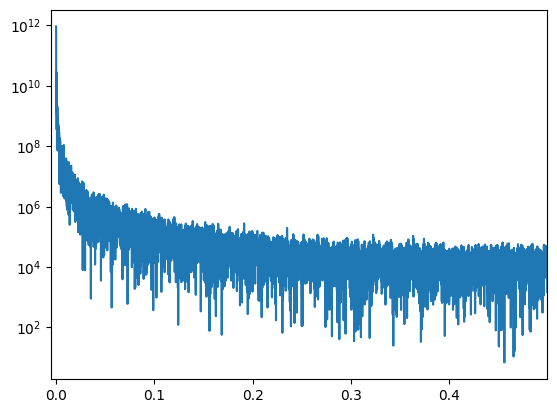

In [33]:
# Number of time steps
N = equispaced_index.size

# frequencies in cycles/delta_t. Only the positive frequencies are taken
# because the function is real and the FFT is symmetric
frequencies = fftfreq(N, d = 1)[:N//2]

# Discrete Fourier Transform computation. Only te values with Re[ft] >= 0 are taken
ft = fft(hist["Open"].values)[:N//2]

max_frequency = np.max(frequencies)

# POwer Spectral Density (fft^2)
psd = np.square(np.abs(ft))

import matplotlib.pyplot as plt

plt.xlim(-0.005,max_frequency)

plt.yscale("log")
plt.plot(frequencies, psd)

Therefore there is no seasonality in the time series. Let's consider the moving average in the validation set with varying window size :